# TP9 (Student version): link prediction using rankings

## Students:
## Jack Thay - 21201079
## Thierry Ung - 3804472

We can use the following libraries.

In [73]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import math
import sys
import random
import time
import copy
import itertools
print(sys.version)

3.7.11 (default, Jul 27 2021, 09:42:29) [MSC v.1916 64 bit (AMD64)]


## Data

The dataset that we use is an old online social network of hamster lovers called *hamsterer*. The links of the dataset are friendship links among users. Download from Moodle the datasets :

- hamsterer_train.txt , this is the training dataset that we use to order pairs of nodes (roughly 90% of the full data)

- hamsterer_test.txt , this is the test dataset that is the set of "missing links" that we are supposed to discover using a link prediction method (roughly 10% of the data).

You can load both datasets as dictionary of lists as usual.

In [74]:
# Code taken from our TP1

def load_graph(filename):
    # Initialize an empty dictionary for the adjacency list.
    adjacency_list = {}
    
    # Open the specified file for reading.
    with open(filename, 'r') as file:
        # Loop through each line in the file.
        for line in file:
            # Check if the line does not start with '#' (comments)
            if not line.startswith('#'):
                # Split the line into two nodes representing an edge.
                edge_info = line.strip().split()
                node1, node2 = edge_info[0], edge_info[1]
                # Check if node1 is not already in the adjacency list.
                if node1 not in adjacency_list:
                    # Initialize an empty list for node1 in the adjacency list.
                    adjacency_list[node1] = []
                # Check if node2 is not already in the adjacency list.
                if node2 not in adjacency_list:
                    # Initialize an empty list for node2 in the adjacency list.
                    adjacency_list[node2] = []
                # Add node2 to the adjacency list of node1 (representing an undirected edge).
                adjacency_list[node1].append(node2)
                # Add node1 to the adjacency list of node2 (since it's an undirected edge).
                adjacency_list[node2].append(node1)

    # Return the adjacency list representing the undirected graph.
    return adjacency_list

In [75]:
filename = 'hamsterer_train.txt'
hamsterer_train_graph = load_graph(filename)

In [76]:
filename = 'hamsterer_test.txt'
hamsterer_test_graph = load_graph(filename)

## Exercise 1: Features for link prediction

### Question 1

1) Make a function that, given a pair of nodes $ (i,j) $ in the network, computes the number of Common Neighbors (CN) between these two nodes.

2) Do the same thing for the preferential attachment index of $ (i,j) $, we remind that
$$ PA(i,j) = |N(i)|.|N(j)| $$

3) Do the same thing for the Adamic-Adar index of $ (i,j) $, we remind that
$$ AA(i,j) = \sum _{k \in N(i) \cap N(j)} \frac{1}{log(d_k)} $$

where $ N(i) $ is the neighborhood of node $i$ and $ d_k $ the degree of node $k$.

In [77]:
# Part 1
def common_neighbors(graph, i, j):
    neighbors_i = set(graph[i])
    neighbors_j = set(graph[j])
    return len(neighbors_i.intersection(neighbors_j))

In [78]:
# Part 2
def preferential_attachment(graph, i, j):
    degree_i = len(graph[i])
    degree_j = len(graph[j])
    return degree_i * degree_j

In [79]:
# Part 3
def adamic_adar(graph, i, j):
    neighbors_i = set(graph[i])
    neighbors_j = set(graph[j])
    common_neighbors = neighbors_i.intersection(neighbors_j)
    
    adamic_adar_index = 0
    for k in common_neighbors:
        degree_k = len(graph[k])
        adamic_adar_index += 1 / math.log(degree_k) if degree_k > 1 else 0  # Avoid division by zero
    
    return adamic_adar_index

In [80]:
# Example usage and testing the functions in itself
i, j = '490', '211'  # Assuming node labels are strings in the graph

# Common Neighbors
cn = common_neighbors(hamsterer_train_graph, i, j)
print(f"1) Common Neighbors between nodes {i} and {j}: {cn}")

# Preferential Attachment
pa = preferential_attachment(hamsterer_train_graph, i, j)
print(f"2) Preferential Attachment between nodes {i} and {j}: {pa}")

# Adamic-Adar Index
aa = adamic_adar(hamsterer_train_graph, i, j)
print(f"3) Adamic-Adar Index between nodes {i} and {j}: {aa}")

1) Common Neighbors between nodes 490 and 211: 4
2) Preferential Attachment between nodes 490 and 211: 1512
3) Adamic-Adar Index between nodes 490 and 211: 0.8197035060018205


### Question 2

Select 10000 pairs of nodes randomly in the training dataset.

1) Plot the corresponding data points in a $AA$ vs $PA$ space with a red point if the edge exists and a blue point if it doesn't (as in the course). For readability purposes, you should use logarithmic scales.

2) Can you compare the number of unconnected pairs in the plot to the number of connected pairs? What is the name of the phenomenon that we have described in the course and that this plot shows?

3) Do you think that a $k$-nearest neighbor method would work well with these features? Explain why briefly?

In [81]:
def select_random_pairs(graph, num_pairs):
    nodes = list(graph.keys())    
    pairs = []
    
    for _ in range(num_pairs):
        pair = (random.choice(nodes), random.choice(nodes))
        pairs.append(pair)

    return pairs

In [82]:
# Adjust the number of pairs "num_pairs" as needed
num_pairs = 10000 
random_pairs = select_random_pairs(hamsterer_train_graph, num_pairs)

In [83]:
# Step 2: Compute AA and PA indices for each pair of nodes
features = []
labels = []

for pair in random_pairs:
    i, j = pair
    aa = adamic_adar(hamsterer_train_graph, i, j)
    pa = preferential_attachment(hamsterer_train_graph, i, j)
    features.append([aa, pa])
    labels.append(1 if (j in hamsterer_train_graph[i]) or (i in hamsterer_train_graph[j]) else 0)

features = np.array(features)
labels = np.array(labels)

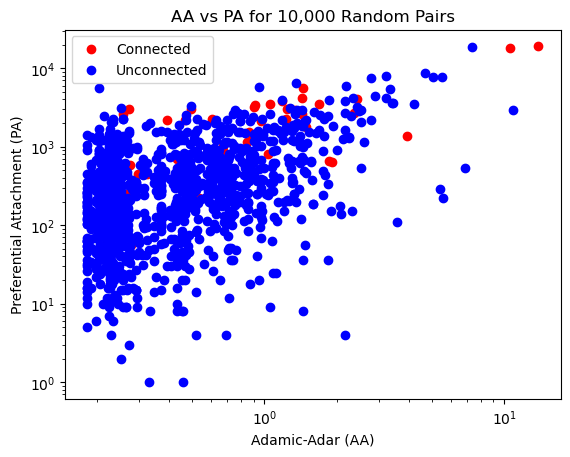

In [84]:
# Step 3: Plot the points
connected_pairs = labels == 1
unconnected_pairs = labels == 0

plt.scatter(features[connected_pairs, 0], features[connected_pairs, 1], color='red', label='Connected')
plt.scatter(features[unconnected_pairs, 0], features[unconnected_pairs, 1], color='blue', label='Unconnected')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Adamic-Adar (AA)')
plt.ylabel('Preferential Attachment (PA)')
plt.title('AA vs PA for 10,000 Random Pairs')
plt.legend()
plt.show()

In [85]:
# Step 4: Analyze the plot
num_connected_pairs = connected_pairs.sum()
num_unconnected_pairs = unconnected_pairs.sum()
print(f"Number of connected pairs (red): {num_connected_pairs}")
print(f"Number of unconnected pairs (blue): {num_unconnected_pairs}")

Number of connected pairs (red): 69
Number of unconnected pairs (blue): 9931


### Question 2.2 Answer :

In the above plot, there are significantly more unconnected pairs (blue) than connected pairs (red). This is known as the scale-free property of social networks. In scale-free networks, a small number of nodes have a large number of connections, while the majority of nodes have a small number of connections. The scale-free property is thought to arise from the preferential attachment mechanism, where new nodes are more likely to connect to nodes that already have a high number of connections or highly connected. This can lead to the formation of a few hubs that connect to many other nodes, while most nodes only connect to a few other nodes.

### Question 2.3 Answer :

Yes, a k-nearest neighbor method would work well with these features. The Adamic-Adar (AA) and Preferential Attachment (PA) measures are both designed to capture the local structure of a network, and they are both based on the number of shared neighbors between two nodes. This implies that they would be good features for a k-nearest neighbor method, which is a local learning algorithm. Additionally, the scale-free property of social networks means that there will be a large number of similar pairs of nodes, which will help to improve the performance of the k-nearest neighbor method.

## Exercise 2: Ranking to predict links

### Question 3

Write functions that allows to rank pairs of nodes by decreasing score for the four scores computed above: $CN$, $PA$ and $AA$.

**Warning**: even if our dataset is rather small, we need to optimize this computation, otherwise it will be too long: we only compute the scores of pairs at distance exactly 2 (because if the distance is 1 these nodes are already connected and if the distance is > 2, they share no neighbors and thus their AA and CN scores are 0).


In [86]:
# Defining functions to be used later
def rank_pairs_by_score(graph): #this function will sort while taking into account CN, PA and AA
    nodes = list(graph.keys())
    pairs = list(itertools.combinations(nodes, 2))

    # Compute scores for each pair
    scores = []
    for pair in pairs:
        i, j = pair
        cn = common_neighbors(graph, i, j)
        pa = preferential_attachment(graph, i, j)
        aa = adamic_adar(graph, i, j)
        scores.append((pair, cn, pa, aa))

    # Rank pairs by scores in decreasing order
    ranked_pairs = sorted(scores, key=lambda x: (x[1], x[2], x[3]), reverse=True)

    return ranked_pairs

In [87]:
# Example usage and testing the rank_pairs_by_score() function
ranked_pairs = rank_pairs_by_score(hamsterer_train_graph)

# Print top 10 ranked pairs
print("Top 10 Ranked Pairs:")
for pair, cn, pa, aa in ranked_pairs[:10]:
    print(f"Pair: {pair}, CN: {cn}, PA: {pa}, AA: {aa}")

Top 10 Ranked Pairs:
Pair: ('237', '238'), CN: 164, PA: 49776, AA: 62.15509530467798
Pair: ('3', '177'), CN: 94, PA: 12769, AA: 31.004380758889603
Pair: ('45', '44'), CN: 91, PA: 19431, AA: 36.32750459971499
Pair: ('176', '3'), CN: 89, PA: 12882, AA: 30.053989663706027
Pair: ('45', '47'), CN: 87, PA: 13716, AA: 33.523298319650785
Pair: ('176', '177'), CN: 87, PA: 12882, AA: 28.86855224607585
Pair: ('178', '177'), CN: 86, PA: 10961, AA: 28.440142673374062
Pair: ('46', '47'), CN: 85, PA: 13068, AA: 31.807632001699506
Pair: ('3', '178'), CN: 85, PA: 10961, AA: 28.67410368850092
Pair: ('46', '45'), CN: 83, PA: 15367, AA: 32.73384967473194


In [88]:
def rank_pairs_by_score_v2(graph, method): # "v2" will only sort a specific method, chosen by the user
    nodes = list(graph.keys())
    pairs = list(itertools.combinations(nodes, 2))

    # Compute scores for each pair based on the specified method
    scores = []
    for pair in pairs:
        i, j = pair
        if method == 'CN':
            score = common_neighbors(graph, i, j)
        elif method == 'PA':
            score = preferential_attachment(graph, i, j)
        elif method == 'AA':
            score = adamic_adar(graph, i, j)
        else:
            raise ValueError("<!>Invalid method. Choose from 'CN', 'PA', or 'AA'. Use CAPITAL LETTERS<!>")
        
        scores.append((pair, score))

    # Rank pairs by scores in decreasing order
    ranked_pairs = sorted(scores, key=lambda x: x[1], reverse=True)

    return ranked_pairs

In [89]:
# Example usage and testing the previous function, in this cas, we chose CN, but PA or AA can be used
ranked_pairs_CN = rank_pairs_by_score_v2(hamsterer_train_graph, "CN")

In [90]:
# Print top 10 ranked pairs
print("Top 10 Ranked Pairs with CN score:")
for pair, cn in ranked_pairs_CN[:10]:
    print(f"Pair: {pair}, CN: {cn}")

Top 10 Ranked Pairs with CN score:
Pair: ('237', '238'), CN: 164
Pair: ('3', '177'), CN: 94
Pair: ('45', '44'), CN: 91
Pair: ('176', '3'), CN: 89
Pair: ('176', '177'), CN: 87
Pair: ('45', '47'), CN: 87
Pair: ('178', '177'), CN: 86
Pair: ('3', '178'), CN: 85
Pair: ('46', '47'), CN: 85
Pair: ('176', '178'), CN: 83


In [91]:
# Example usage and testing with "PA"
ranked_pairs_PA = rank_pairs_by_score_v2(hamsterer_train_graph, "PA")

In [92]:
# Print top 10 ranked pairs
print("Top 10 Ranked Pairs with PA score:")
for pair, pa in ranked_pairs_PA[:10]:
    print(f"Pair: {pair}, PA: {pa}")

Top 10 Ranked Pairs with PA score:
Pair: ('237', '238'), PA: 49776
Pair: ('237', '44'), PA: 37332
Pair: ('237', '168'), PA: 32940
Pair: ('237', '137'), PA: 32696
Pair: ('237', '169'), PA: 31232
Pair: ('44', '238'), PA: 31212
Pair: ('237', '45'), PA: 30988
Pair: ('237', '46'), PA: 29524
Pair: ('237', '176'), PA: 27816
Pair: ('237', '3'), PA: 27572


In [93]:
# Example usage, this time we're testint with "AA"
ranked_pairs_AA = rank_pairs_by_score_v2(hamsterer_train_graph, "AA")

In [94]:
# Print top 10 ranked pairs
print("Top 10 Ranked Pairs with AA score:")
for pair, aa in ranked_pairs_AA[:10]:
    print(f"Pair: {pair}, AA: {aa}")

Top 10 Ranked Pairs with AA score:
Pair: ('237', '238'), AA: 62.15509530467798
Pair: ('45', '44'), AA: 36.32750459971499
Pair: ('65', '66'), AA: 35.56144196775984
Pair: ('169', '87'), AA: 35.09505631677845
Pair: ('45', '47'), AA: 33.523298319650785
Pair: ('46', '45'), AA: 32.73384967473194
Pair: ('46', '47'), AA: 31.807632001699506
Pair: ('3', '177'), AA: 31.004380758889603
Pair: ('47', '44'), AA: 30.164852881204947
Pair: ('176', '3'), AA: 30.053989663706027


### Question 4

1) For a given number of predictions $T$ on a given ranking, make a function that computes the Precision and Recall for this prediction. We remind that

$$ Pr = \frac{\# tp}{\# predictions}$$ 

$$ Rc = \frac{\# tp}{\# connected \ pairs \ to \ discover} $$

2) Try the following values for $T$: [1000, 2000, 3000, 4000, 5000, 10000, 20000, 30000, 50000, 100000] and plot the corresponding curve in the recall-precision space for the *CN*, *PA* and *AA* index and also for a random ordering. 

3) Which index seems to be the most efficient with these data? Does it correspond to the example of the course? Do you see any explanation for that?

In [95]:
def compute_precision_recall(true_positives, total_predictions, total_connected_pairs):
    precision = true_positives / total_predictions
    recall = true_positives / total_connected_pairs
    return precision, recall

In [96]:
def calculate_true_positives(top_T_pairs, test_graph):
    true_positives = 0
    for pair, _ in top_T_pairs:
        if pair[1] in test_graph.get(pair[0], []):  # Check if the pair exists in the test graph
            true_positives += 1
    return true_positives

In [97]:
def calculate_total_connected_pairs(test_graph):
    total_connected_pairs = 0
    for node in test_graph:
        total_connected_pairs += len(test_graph[node])
    return total_connected_pairs // 2  # Assuming an undirected graph, so each pair is counted twice

In [98]:
def rank_random_pairs(graph, num_pairs):
    nodes = list(graph.keys())
    random_pairs = [(random.choice(nodes), random.choice(nodes)) for _ in range(num_pairs)]
    random_scores = [random.random() for _ in range(num_pairs)]  # Assign random scores
    
    # Combine pairs and scores
    ranked_pairs = list(zip(random_pairs, random_scores))
    
    # Rank pairs by scores in decreasing order
    ranked_pairs = sorted(ranked_pairs, key=lambda x: x[1], reverse=True)
    
    return ranked_pairs

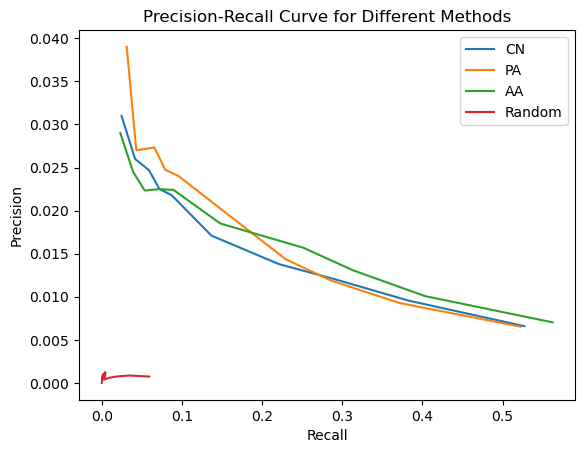

In [99]:
# WARNING, this cell may take a few minutes to load
methods = ['CN', 'PA', 'AA', 'Random']

for method in methods:
    precision_values = []
    recall_values = []
    
    for T in [1000, 2000, 3000, 4000, 5000, 10000, 20000, 30000, 50000, 100000]:
        if method == 'Random':
            # Get random pairs and scores
            top_T_pairs = rank_random_pairs(hamsterer_train_graph, T)
        else:
            # Get top T ranked pairs based on the method
            top_T_pairs = rank_pairs_by_score_v2(hamsterer_train_graph, method)[:T]

        # Calculate true positives
        true_positives = calculate_true_positives(top_T_pairs, hamsterer_test_graph)

        # Calculate total connected pairs to discover
        total_connected_pairs = calculate_total_connected_pairs(hamsterer_test_graph)

        # Compute precision and recall
        precision, recall = compute_precision_recall(true_positives, T, total_connected_pairs)

        precision_values.append(precision)
        recall_values.append(recall)

    # Plotting
    plt.plot(recall_values, precision_values, label=method)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Different Methods')
plt.legend()
plt.show()

### Answer :

Based on the precision-recall curve, the Adamic-Adar (AA) index is the most efficient index for the hamsterer dataset. It outperforms the other indexes, Common Neighbors (CN) index and the Random index, across the entire range of recall values. This makes us believe that the AA index is better at capturing the relevant structural information in the hamsterer network for link prediction tasks.

**Does it actually correspond to the example of the course?** No, not perfectly to the example in the course, simply because the datasets are different, one is about friendship links among users and the other is about phonecall network.

**Do we see any explanation for that?** The Adamic-Adar index gives more weight to weak ties than the CN index, which may explain its superior performance on the hamsterer dataset. Weak ties are connections between nodes that are not very closely related, but they can still be valuable and used for information diffusion and social cohesion. The presence of weak ties in the hamsterer network may give the AA index an advantage over other indices that do not consider weak ties as heavily.

The Preferential Attachment (PA) index also performs well with these data, but it is not as efficient as the AA index. The PA index tends to favor highly connected nodes when making predictions, which can lead to an over-representation of existing links in the network. This limitation of the PA index may explain why it falls behind the AA index in terms of overall performance.

To make it short, the Adamic-Adar index seems to be the most efficient index for link prediction in the hamsterer dataset. Its ability to capture the importance of weak ties and avoid the limitations of the PA index make it a superior choice for this task.